# Test 4
### Fit neural network based lens potential perturbations on a smooth SIE model and an elliptical Sérsic source.
The potential perturbation here is a single localised substructure on the Einstein ring.

__last update__: 20/07/21

In [1]:
# Basic imports
from time import time
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import optax  
import os
from pathlib import Path
import imageio

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
from jax import jit, vmap

# Basic FLAX
from flax import linen as nn           
from flax.training import train_state  
from flax.core.frozen_dict import freeze

# JAX-ified lenstronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Util import image_util,models

# Universal font size
FS = 18

### Data grids (image plane and source plane)

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = [x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]]

# Lower resolution interpolation grid
npix_lowres = npix // 4
x_coords_lowres = np.linspace(extent[0], extent[1], npix_lowres)
y_coords_lowres = np.linspace(extent[2], extent[3], npix_lowres)
x_grid_lowres, y_grid_lowres = np.meshgrid(x_coords_lowres, y_coords_lowres)

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
                        'center_x': 0.4, 'center_y': 0.15}]

### Lens models (large-scale SIE + an SIE perturber)

In [4]:
# True lens mass model
true_lens_mass_model_list = ['SIE', 'SIE']
true_lens_mass_model = LensModel(true_lens_mass_model_list)
kwargs_true_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                         {'theta_E': 0.25, 'e1': 0.0, 'e2': 0.0, 'center_x': 1.9, 'center_y': -0.4}]

# Hybrid lens mass model
hybrid_lens_mass_model_list = ['SIE', 'NETWORK']
hybrid_lens_mass_model = LensModel(hybrid_lens_mass_model_list)


# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

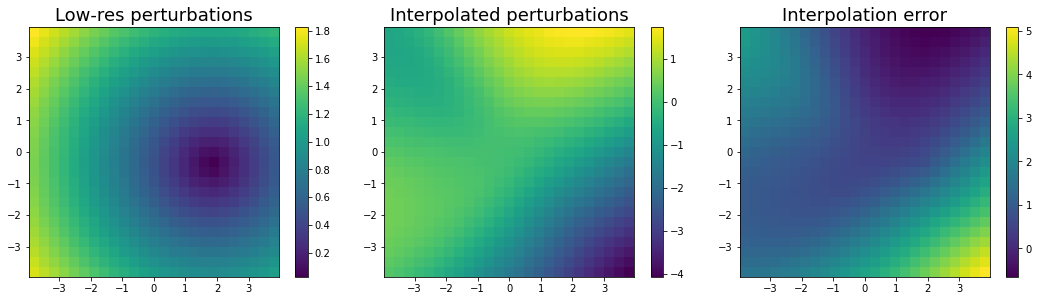

In [5]:
# Extract the true perturbation potential on original and low-res grids
psi_grid_true = true_lens_mass_model.potential(x_grid, y_grid, kwargs_true_lens_mass, k=1)
psi_grid_true_lowres = true_lens_mass_model.potential(x_grid_lowres, y_grid_lowres, kwargs_true_lens_mass, k=1)

# Set the hybrid lens mass model parameters (initialize network params and optimizer)
rng = jax.random.PRNGKey(8)
rng, init_rng = jax.random.split(rng)
state = models.create_train_state(init_rng,learning_rate=0.01,input_size=2,hidden_sizes=(100,100,1))
kwargs_hybrid_lens_mass = [kwargs_true_lens_mass[0],{'state':state.params}] 

# Random prediction (network not trained yet)
psi_grid_interp = hybrid_lens_mass_model.potential(x_grid_lowres, y_grid_lowres, kwargs_hybrid_lens_mass,k=1)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
img1 = axes[0].imshow(psi_grid_true_lowres, origin='lower', extent=extent)
axes[0].set_title("Low-res perturbations", fontsize=FS)
img2 = axes[1].imshow(psi_grid_interp, origin='lower', extent=extent)
axes[1].set_title("Interpolated perturbations", fontsize=FS)
img3 = axes[2].imshow(psi_grid_true_lowres - psi_grid_interp, origin='lower', extent=extent)
axes[2].set_title("Interpolation error", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

### PSF
Ignore the PSF for now.

In [6]:
kwargs_psf = {'psf_type': 'NONE', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Noise

In [7]:
# Noise
exp_time = 100
sigma_bkd = 0.05
kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)
noise_hybrid = deepcopy(noise)

### Image model

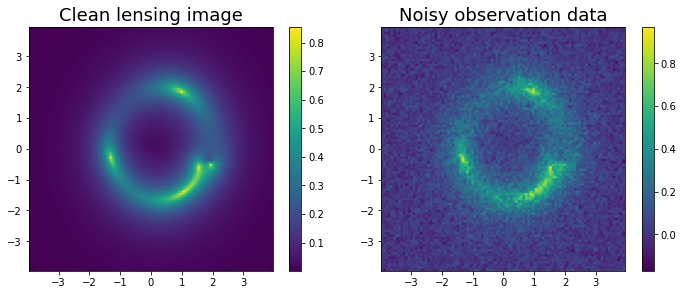

In [8]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
lens_image = LensImage(pixel_grid, psf,
                       noise_class=noise,
                         lens_model_class=true_lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image = lens_image.model(kwargs_lens=kwargs_true_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)


# Observed noisy data
data = lens_image.simulation(kwargs_lens=kwargs_true_lens_mass,
                             kwargs_source=kwargs_source_light,
                             kwargs_lens_light=kwargs_lens_light)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', extent=extent)
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower', extent=extent)
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

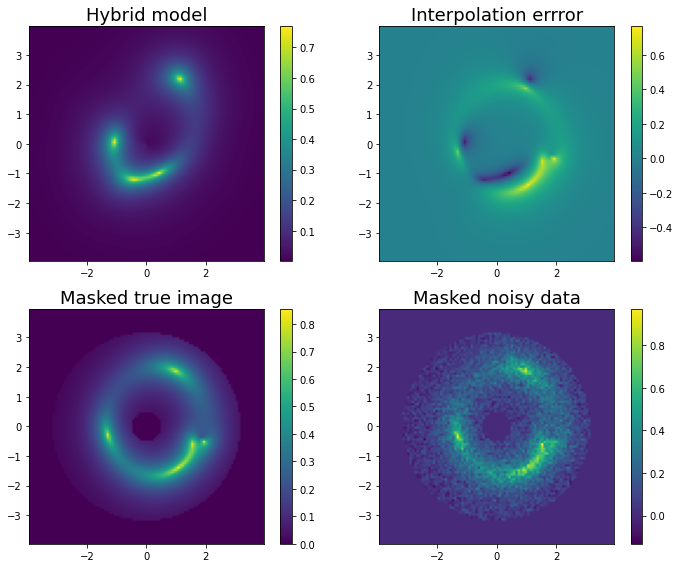

In [9]:
# Define a new noise class with true error map from the simulation above
kwargs_noise_hybrid = {'background_rms': sigma_bkd, 'noise_map': np.sqrt(lens_image.Noise.C_D)}
noise_hybrid = Noise(npix, npix, **kwargs_noise_hybrid)

# Hybrid image model for fitting
hybrid_lens_image = LensImage(pixel_grid, psf, noise_class=noise_hybrid,
                                lens_model_class=hybrid_lens_mass_model,
                                source_model_class=source_light_model,
                                lens_light_model_class=lens_light_model,
                                kwargs_numerics=kwargs_numerics)

# Test the hybrid model (results are gonna be bad since network is not trained)
hybrid_image = hybrid_lens_image.model(kwargs_lens=kwargs_hybrid_lens_mass,
                                        kwargs_source=kwargs_source_light,
                                        kwargs_lens_light=kwargs_lens_light)

# Generate a mask
rmin = 0.5
rmax = 3.2
# Original grid
radius = np.hypot(x_grid, y_grid)
mask = ((radius >= rmin) & (radius <= rmax)).astype(float)
# Low-res grid
radius_lowres = np.hypot(x_grid_lowres, y_grid_lowres)
mask_lowres = ((radius_lowres >= rmin) & (radius_lowres <= rmax)).astype(float)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
(ax1, ax2), (ax3, ax4) = axes
img1 = ax1.imshow(hybrid_image, origin='lower', extent=extent)
img2 = ax2.imshow(image - hybrid_image, origin='lower', extent=extent)
img3 = ax3.imshow(mask * image, origin='lower', extent=extent)
img4 = ax4.imshow(mask * data, origin='lower', extent=extent)
ax1.set_title("Hybrid model", fontsize=FS)
ax2.set_title("Interpolation errror", fontsize=FS)
ax3.set_title("Masked true image", fontsize=FS)
ax4.set_title("Masked noisy data", fontsize=FS)
for img, ax in zip((img1, img2, img3, img4), np.ravel(axes)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

### Network training (temporarily outside the library)

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298
300
302
304
306
308
310
312
314
316
318
320
322
324
326
328
330
332
334
336
338
340
342
344
346
348
350
352
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
456
458
460
462
464
466
468
470
472
474
476
478
480
482
484
486
488
490
492
494
496
498
500
502
504
506
508
510
512
514
516
518
520
522
524
526
5

3500
3502
3504
3506
3508
3510
3512
3514
3516
3518
3520
3522
3524
3526
3528
3530
3532
3534
3536
3538
3540
3542
3544
3546
3548
3550
3552
3554
3556
3558
3560
3562
3564
3566
3568
3570
3572
3574
3576
3578
3580
3582
3584
3586
3588
3590
3592
3594
3596
3598
3600
3602
3604
3606
3608
3610
3612
3614
3616
3618
3620
3622
3624
3626
3628
3630
3632
3634
3636
3638
3640
3642
3644
3646
3648
3650
3652
3654
3656
3658
3660
3662
3664
3666
3668
3670
3672
3674
3676
3678
3680
3682
3684
3686
3688
3690
3692
3694
3696
3698
3700
3702
3704
3706
3708
3710
3712
3714
3716
3718
3720
3722
3724
3726
3728
3730
3732
3734
3736
3738
3740
3742
3744
3746
3748
3750
3752
3754
3756
3758
3760
3762
3764
3766
3768
3770
3772
3774
3776
3778
3780
3782
3784
3786
3788
3790
3792
3794
3796
3798
3800
3802
3804
3806
3808
3810
3812
3814
3816
3818
3820
3822
3824
3826
3828
3830
3832
3834
3836
3838
3840
3842
3844
3846
3848
3850
3852
3854
3856
3858
3860
3862
3864
3866
3868
3870
3872
3874
3876
3878
3880
3882
3884
3886
3888
3890
3892
3894
3896
3898


6778
6780
6782
6784
6786
6788
6790
6792
6794
6796
6798
6800
6802
6804
6806
6808
6810
6812
6814
6816
6818
6820
6822
6824
6826
6828
6830
6832
6834
6836
6838
6840
6842
6844
6846
6848
6850
6852
6854
6856
6858
6860
6862
6864
6866
6868
6870
6872
6874
6876
6878
6880
6882
6884
6886
6888
6890
6892
6894
6896
6898
6900
6902
6904
6906
6908
6910
6912
6914
6916
6918
6920
6922
6924
6926
6928
6930
6932
6934
6936
6938
6940
6942
6944
6946
6948
6950
6952
6954
6956
6958
6960
6962
6964
6966
6968
6970
6972
6974
6976
6978
6980
6982
6984
6986
6988
6990
6992
6994
6996
6998
7000
7002
7004
7006
7008
7010
7012
7014
7016
7018
7020
7022
7024
7026
7028
7030
7032
7034
7036
7038
7040
7042
7044
7046
7048
7050
7052
7054
7056
7058
7060
7062
7064
7066
7068
7070
7072
7074
7076
7078
7080
7082
7084
7086
7088
7090
7092
7094
7096
7098
7100
7102
7104
7106
7108
7110
7112
7114
7116
7118
7120
7122
7124
7126
7128
7130
7132
7134
7136
7138
7140
7142
7144
7146
7148
7150
7152
7154
7156
7158
7160
7162
7164
7166
7168
7170
7172
7174
7176


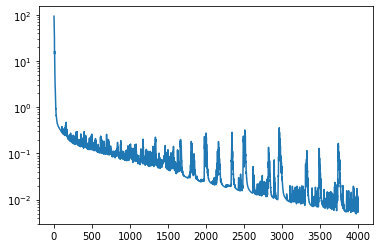

In [10]:
%%time
target=image   ###### data for noise-corrupted target, image for clean target




plot=False
num_epochs=8000
trend=[]
#noise_add = noise.C_D #### handle likelihood variance
noise_add = 1. #### handle likelihood variance
for epoch in range(1, num_epochs + 1):
    rng, input_rng = jax.random.split(rng)
    state = hybrid_lens_image.train_step(state,target,noise_add=noise_add,
                       main_mass=kwargs_true_lens_mass[0], kwargs_source=kwargs_source_light,kwargs_lens_light=kwargs_lens_light)
    if epoch % 2 == 0:
        kwargs_hybrid_lens_mass = [kwargs_true_lens_mass[0],{'state':state.params}] 
        psi_grid_interp = hybrid_lens_mass_model.potential(x_grid, y_grid, kwargs_hybrid_lens_mass,k=1)
        psi_grid_true = true_lens_mass_model.potential(x_grid, y_grid, kwargs_true_lens_mass, k=1)
        loss = hybrid_lens_image.eval_step(target, noise_add=noise_add,
                                main_mass=kwargs_true_lens_mass[0], kwargs_source=kwargs_source_light,kwargs_lens_light=kwargs_lens_light,params=state.params)
        trend.append(loss)
        if plot:
            fig, axes = plt.subplots(1, 3, figsize=(14, 5))
            (ax1, ax2,ax3) = axes
            img1=ax1.imshow((psi_grid_interp*mask)+.4,extent=extent)
            ax1.set_title('Prediction')
            fig.colorbar(img1, ax=ax1,fraction=0.046, pad=0.04)
            img2=ax2.imshow((psi_grid_true*mask),extent=extent)
            ax2.set_title('Ground Truth')
            fig.colorbar(img2, ax=ax2,fraction=0.046, pad=0.04)
            img3=ax3.imshow((psi_grid_true*mask)-((psi_grid_interp+.4)*mask),extent=extent)
            ax3.set_title('Error')
            fig.colorbar(img3, ax=ax3,fraction=0.046, pad=0.04)
            #fig.tight_layout()
            plt.figtext(0.5, 0.001, 'Epoch: '+str(epoch), wrap=True, horizontalalignment='center', fontsize=12)
            plt.savefig('Images/im{}'.format(epoch),transparent = True, bbox_inches = 'tight', pad_inches = 0)
            plt.close(fig)
        #plt.show()
        print(epoch)
        #print(loss)

plt.plot(trend)
plt.yscale('log')

if plot:
    dirpath='Images'
    paths = sorted(Path(dirpath).iterdir(), key=os.path.getmtime)[1:]
    images=[]
    for filename in paths:
        images.append(imageio.imread(str(filename)))
    imageio.mimsave('training.gif', images,fps=3)

In [11]:
loss

DeviceArray(0.00949867, dtype=float64)

### Image with trained network

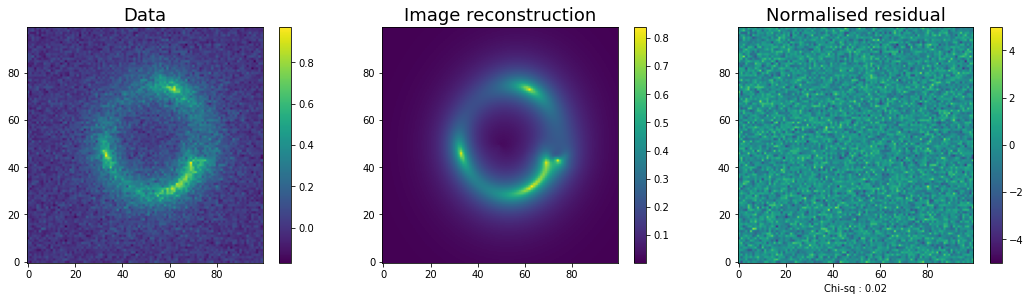

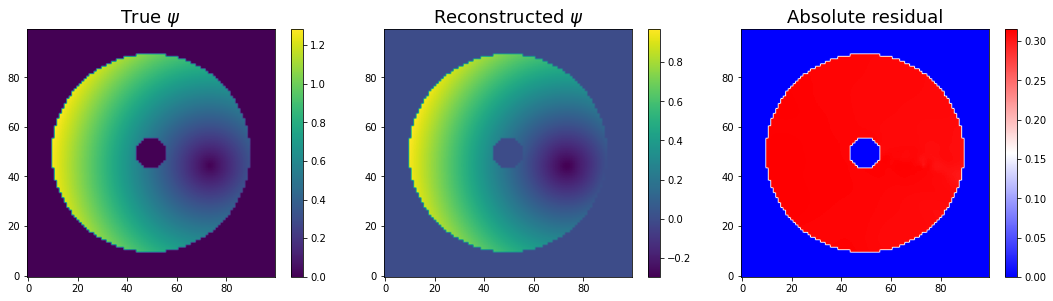

In [12]:
# create the resulting model image
hybrid_lens_image = LensImage(pixel_grid, psf, noise_class=noise_hybrid,
                                lens_model_class=hybrid_lens_mass_model,
                                source_model_class=source_light_model,
                                lens_light_model_class=lens_light_model,
                                kwargs_numerics=kwargs_numerics)
rec_image = hybrid_lens_image.model(kwargs_lens=[kwargs_true_lens_mass[0],{'state':state.params}],
                                                kwargs_source=kwargs_source_light,
                                                kwargs_lens_light=kwargs_lens_light)
noise_var = lens_image.Noise.C_D


fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(data, origin='lower')
ax1.set_title("Data", fontsize=FS)
img2 = ax2.imshow(rec_image, origin='lower')
ax2.set_title("Image reconstruction", fontsize=FS)
img3 = ax3.imshow((data - rec_image) / jnp.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
ax3.set_title("Normalised residual", fontsize=FS)
ax3.set_xlabel(f"Chi-sq : {2 * loss:.2f}")
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()


psi_grid_interp_=psi_grid_interp   ##### shifting factor needed
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(psi_grid_true * mask, origin='lower')
ax1.set_title("True $\psi$", fontsize=FS)
img2 = ax2.imshow(psi_grid_interp_ * mask, origin='lower')
ax2.set_title("Reconstructed $\psi$", fontsize=FS)
img3 = ax3.imshow((psi_grid_true - psi_grid_interp_) * mask, origin='lower', cmap='bwr')
ax3.set_title("Absolute residual", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()


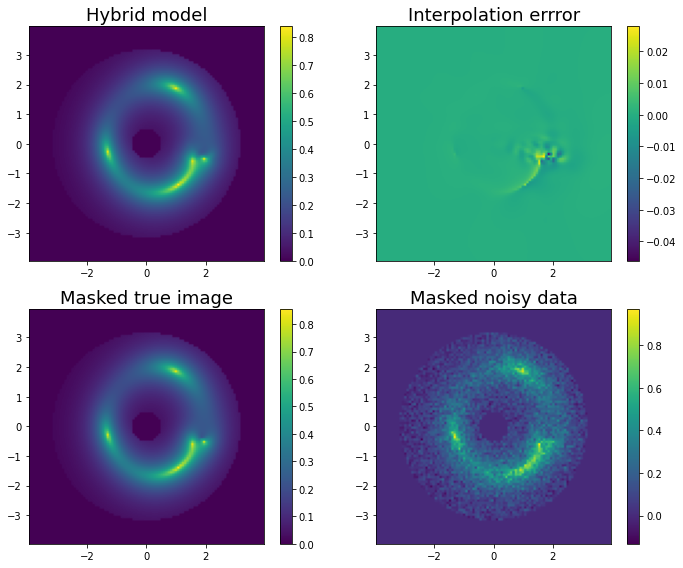

In [13]:
hybrid_image = hybrid_lens_image.model(kwargs_lens=[kwargs_true_lens_mass[0],{'state':state.params}],
                                        kwargs_source=kwargs_source_light,
                                        kwargs_lens_light=kwargs_lens_light)

# Generate a mask
rmin = 0.5
rmax = 3.2
# Original grid
radius = np.hypot(x_grid, y_grid)
mask = ((radius >= rmin) & (radius <= rmax)).astype(float)
# Low-res grid
radius_lowres = np.hypot(x_grid_lowres, y_grid_lowres)
mask_lowres = ((radius_lowres >= rmin) & (radius_lowres <= rmax)).astype(float)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
(ax1, ax2), (ax3, ax4) = axes
img1 = ax1.imshow(hybrid_image*mask, origin='lower', extent=extent)
img2 = ax2.imshow(image - hybrid_image, origin='lower', extent=extent)
img3 = ax3.imshow(image*mask, origin='lower', extent=extent)
img4 = ax4.imshow(data*mask, origin='lower', extent=extent)
ax1.set_title("Hybrid model", fontsize=FS)
ax2.set_title("Interpolation errror", fontsize=FS)
ax3.set_title("Masked true image", fontsize=FS)
ax4.set_title("Masked noisy data", fontsize=FS)
for img, ax in zip((img1, img2, img3, img4), np.ravel(axes)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

### Compare gt and predicted derivatives

Text(0.5, 1.0, 'y-partial derivative (gt)')

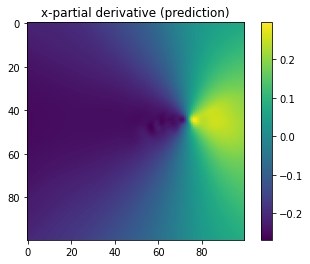

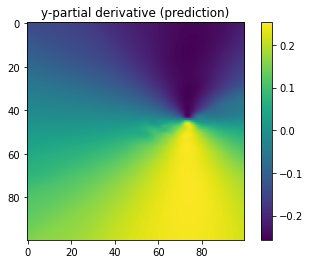

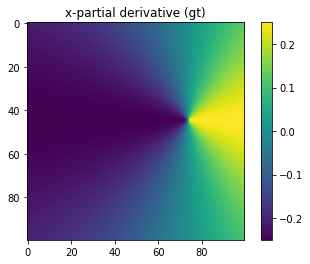

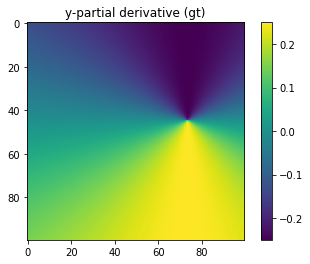

In [14]:
plt.figure()
plt.imshow(hybrid_lens_mass_model.alpha(x_grid, y_grid, kwargs_hybrid_lens_mass,k=1)[0])
plt.colorbar()
plt.title('x-partial derivative (prediction)')

plt.figure()
plt.imshow(hybrid_lens_mass_model.alpha(x_grid, y_grid, kwargs_hybrid_lens_mass,k=1)[1])
plt.colorbar()
plt.title('y-partial derivative (prediction)')

plt.figure()
plt.imshow(true_lens_mass_model.alpha(x_grid, y_grid, kwargs_true_lens_mass,k=1)[0])
plt.colorbar()
plt.title('x-partial derivative (gt)')


plt.figure()
plt.imshow(true_lens_mass_model.alpha(x_grid, y_grid, kwargs_true_lens_mass,k=1)[1])
plt.colorbar()
plt.title('y-partial derivative (gt)')